# Network Generators in konnektor

In this Notebook we briefly describe many of the network topologies available in Konnektor.

In [2]:
# NBVAL_SKIP
# Only run this cell if on google colab
import os
if "COLAB_RELEASE_TAG" in os.environ:
    !pip install -U https://github.com/conda-incubator/condacolab/archive/cuda-version-12.tar.gz
    import condacolab
    condacolab.install_mambaforge()
    !wget -q https://raw.githubusercontent.com/OpenFreeEnergy/konnektor/main/examples/environment.yaml
    !mamba env update -q --name=base --file=environment.yaml
        
    from google.colab import output
    output.enable_custom_widget_manager()

## Generating randomized input data

First we generate a randomized toy input dataset.

Note that these only work in combinatioin with each other! A real world example can be found in the konnektor_example notebook.

In [3]:
from konnektor.visualization import draw_ligand_network

from konnektor.utils.toy_data import build_random_dataset

components, mapper, scorer = build_random_dataset(n_compounds=30, rand_seed=None)

Feel free to play with the parameters, `n_compounds` controls the number of compounds, and `rand_seed` can be used to change the random seed.

## Star Network
The Star Network is one of the most edge efficient layouts, connecting all the `Component`s to one central `Component`.

The default algorithm is as follows:

1. Constructs all the possible connections between the `Component`s.
2. Select the `Component` is the best average connection score as the central `Component`.
3. Only retain connections to this central `Component`.

Whilst this network is most efficient in terms of edges, it does not necessarily have the most efficient set of connections. This is because a central `Component` has to be chosen, which is often a compromise for all `Component`s (i.e. it may not be the easier `Component` to transform to, it just happens to have the best average connection score).

From a robustness point of view, the Star Network, will immediatly be disconnected if one connection fails. However the loss of `Component`s is very limited, as only one `Component` is lost per failure.

In [4]:
from konnektor.network_planners import StarNetworkGenerator

ligand_network_planner = StarNetworkGenerator(
    mappers=mapper, scorer=scorer, n_processes=1
)

In [5]:
star_network = ligand_network_planner.generate_ligand_network(components)
star_network.name = "Star Network"
star_network

<LigandNetwork-45326a9c0a6af87b4b3324b22ee25a56>

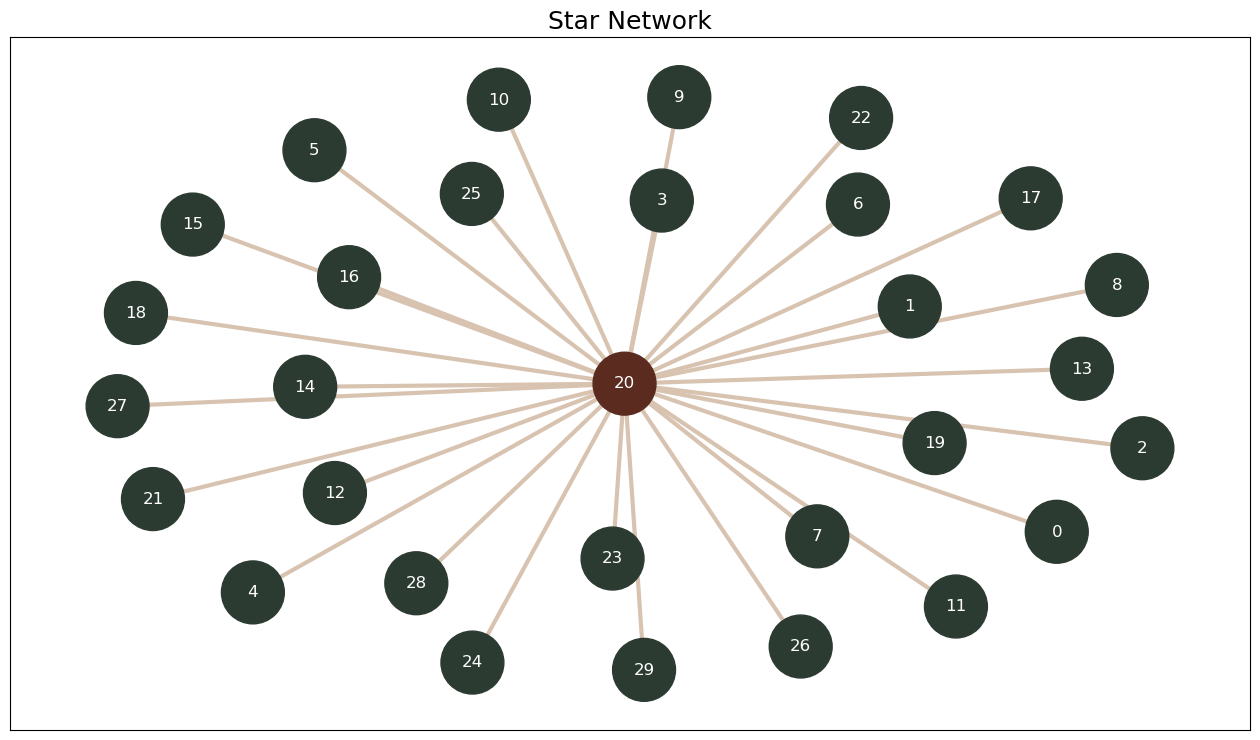

In [6]:
draw_ligand_network(network=star_network, title=star_network.name);

## Twin Star Network
The Twin Star Network is an expansion to the Star Network. It can be described as multiple star networks, that are overlayed. 


The default algorithm is as follows:

1. Constructs all the possible connections between the Components.
2. The `n_centers` `Component`s with the best average connection scores are selected an placed into the center of the network.
3. All the components are connected to the selected central `Components`, resulting in $n_{connections} = n_{centers}*(n_{Components}-n_{centers})$.

**Note:** The `n_centers` option allows you to change the Twin Star to a Triplet Star Network or more.

This approach leads to double the number of connections compared to the `Star Network` and therefore has a higher cost to complete. However, it builds a lot of graph cycles which add redundancy and allow for cycle closure analysis.

Similarly to the `Star Network`, node connectivity is centralized around the `n_centers`. This means, that the selection of the central ligands is very important.

In [7]:
from konnektor.network_planners import TwinStarNetworkGenerator

ligand_network_planner = TwinStarNetworkGenerator(
    mappers=mapper, scorer=scorer, n_centers=2
)

In [8]:
twin_star_network = ligand_network_planner.generate_ligand_network(components)
twin_star_network.name = "Twin Star Network"
twin_star_network

<LigandNetwork-fc501fecb85aa6ab074906c4e956baf4>

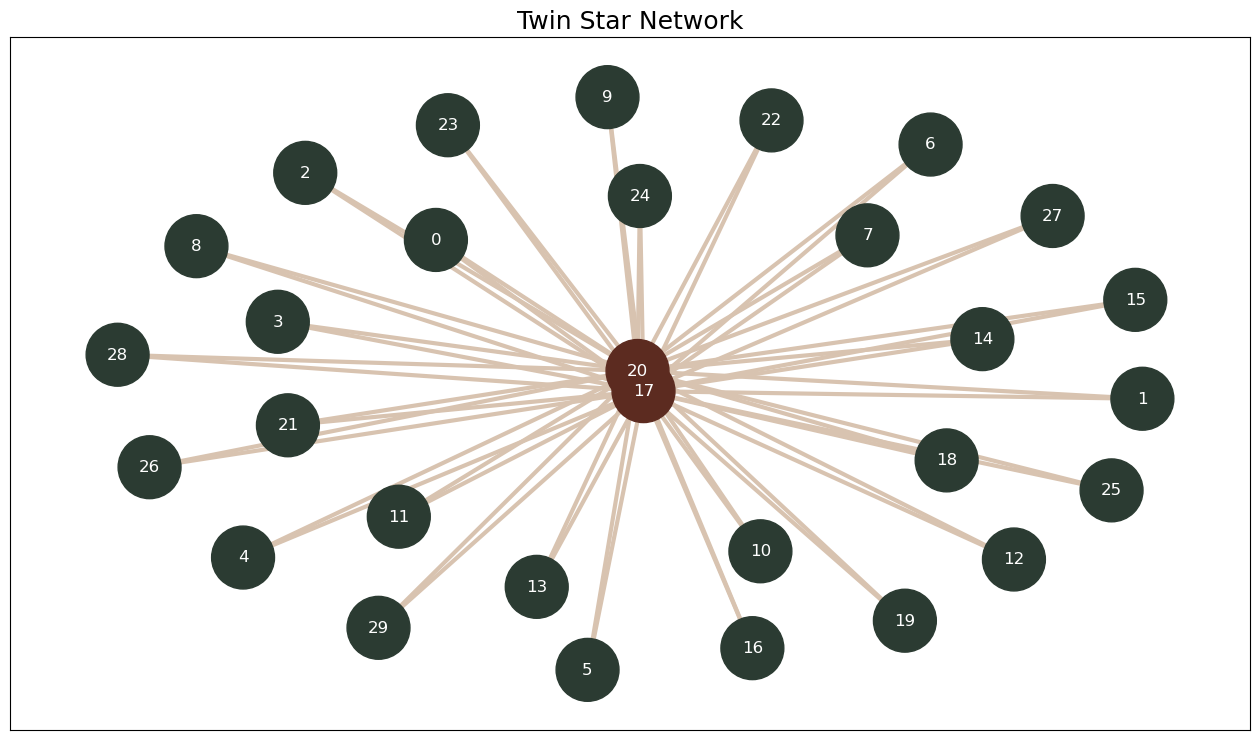

In [9]:
draw_ligand_network(network=twin_star_network, title=twin_star_network.name);

## Starry Sky Network
The StarrySkyNetworkGenerator is an advanced network algorithm, that clusters the provided `Component`s and builds up a network from these clusters.

The network algorithm follows the following steps:
1. Component clustering:
    1. Translate the Molecules into Morgan Fingerprints. (default)
    2. Cluster the Morgan Fingerprints with HDBSCAN. (default)
2. Build Sub-Star Networks for each Cluster using the `StarNetworkGenerator`.
3. Concatenate the Sub-Star Networks to the final Starry  Sky Network, with 3 connections per cluster pair using the `MSTConcatenator`.

This approach allows networks to be built with portions of the `Component`s connected to a central `Component` that is most representative of a given feature. This can lead to an improved graph score.

This does come at the cost of a higher number of connections (compared to a `Star Network`), but not as much as the number which would be generated by a `Twin Star Network` with the same number of `Component`s.

In [10]:
from sklearn.cluster import HDBSCAN
from scikit_mol.fingerprints import MorganFingerprintTransformer
from konnektor.network_tools import ComponentsDiversityClusterer
from konnektor.network_planners import StarrySkyNetworkGenerator

ligand_network_planner = StarrySkyNetworkGenerator(
    mappers=mapper,
    scorer=scorer,
    clusterer=ComponentsDiversityClusterer(
        featurize=MorganFingerprintTransformer(),
        cluster=HDBSCAN(metric="jaccard", min_cluster_size=3, alpha=1 / 2048),
    ),
    n_processes=1,
)

In [11]:
starry_sky_network = ligand_network_planner.generate_ligand_network(components)
starry_sky_network.name = "Starry Sky Network"
starry_sky_network

/Users/atravitz/micromamba/envs/konnektor/lib/python3.12/site-packages/gufe/components/explicitmoleculecomponent.py:74: UserWarning: RDKit does not preserve Mol properties when pickled by default, which may drop e.g. atom charges; consider setting `Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)`
  warnings.warn(
/Users/atravitz/micromamba/envs/konnektor/lib/python3.12/site-packages/gufe/components/explicitmoleculecomponent.py:74: UserWarning: RDKit does not preserve Mol properties when pickled by default, which may drop e.g. atom charges; consider setting `Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)`
  warnings.warn(
/Users/atravitz/micromamba/envs/konnektor/lib/python3.12/site-packages/gufe/components/explicitmoleculecomponent.py:74: UserWarning: RDKit does not preserve Mol properties when pickled by default, which may drop e.g. atom charges; consider setting `Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)`
  warning

<LigandNetwork-37f472b20294fc639eee6eb883a3bc52>

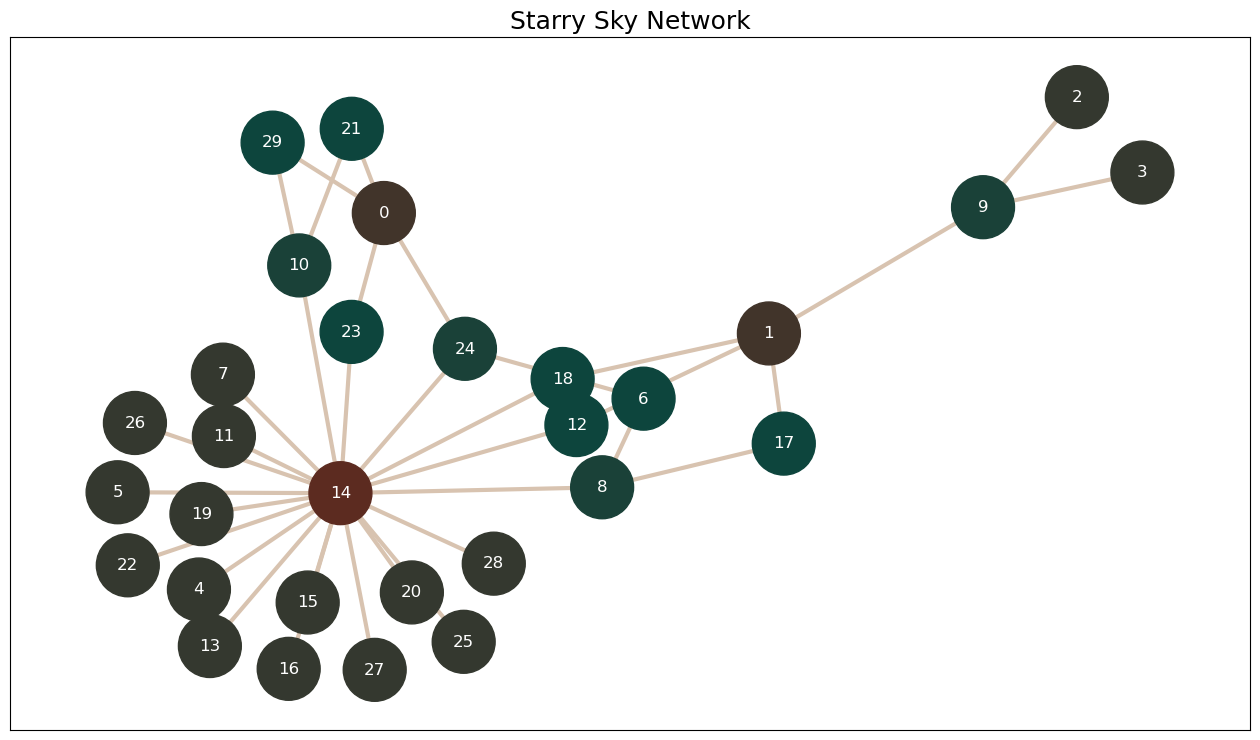

In [12]:
draw_ligand_network(network=starry_sky_network, title=starry_sky_network.name);

## Minimal Spanning Tree
The `MinimalSpanningTreeNetworkGenerator`, builds a minimal spanning tree (MST) network for a given set of `Component`s.

For the MST algorithm the Kruskal Algorithm is used.

The MST algorithm gives the optimal graph score possible and the minimal required set of connections to make sure all the `Component` nodes are connected.

This makes the  MST Network very efficient. However, the MST is not very robust as one failed connection wwill lead to the network being immediatly disconnected.

In [13]:
from konnektor.network_planners import MinimalSpanningTreeNetworkGenerator

ligand_network_planner = MinimalSpanningTreeNetworkGenerator(
    mappers=mapper, scorer=scorer
)

In [14]:
mst_network = ligand_network_planner.generate_ligand_network(components)
mst_network.name = "Min Spanning Tree Network"
mst_network

<LigandNetwork-7b90cad091710e7dee855e11f3029347>

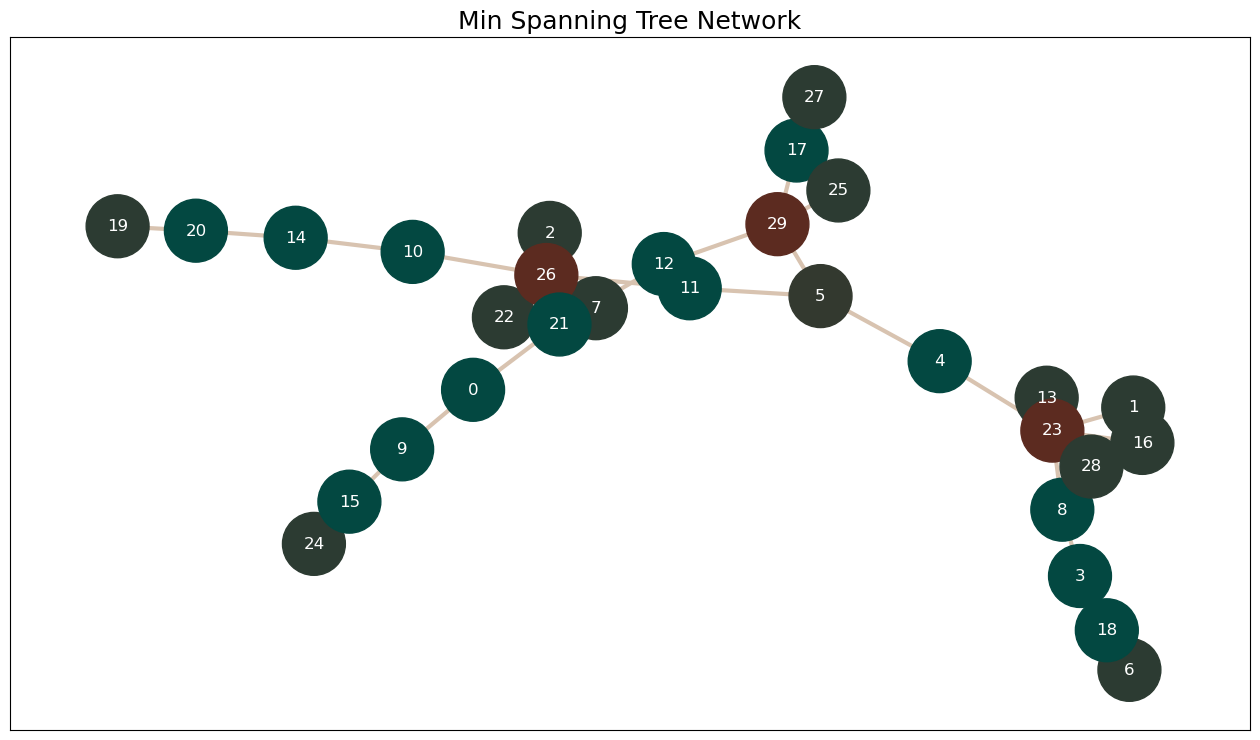

In [15]:
draw_ligand_network(network=mst_network, title=mst_network.name);

## N-Node Edges Network
The N-Node Edges Network tries to add more redundancy to the MST Network to improve the robustness.

The network algorithm follows the following steps:
1. Build an MST Network.
2. Add the best scoring connections trying to reach `target_node_connectivity` for each `Component`.


In [16]:
from konnektor.network_planners import NNodeEdgesNetworkGenerator

ligand_network_planner = NNodeEdgesNetworkGenerator(
    mappers=mapper, scorer=scorer, target_component_connectivity=3
)

In [17]:
nedges_network = ligand_network_planner(components)
nedges_network.name = "N-Edges Network"
nedges_network

<LigandNetwork-971fe6d9cd4b844bf0c353371a9d1d3e>

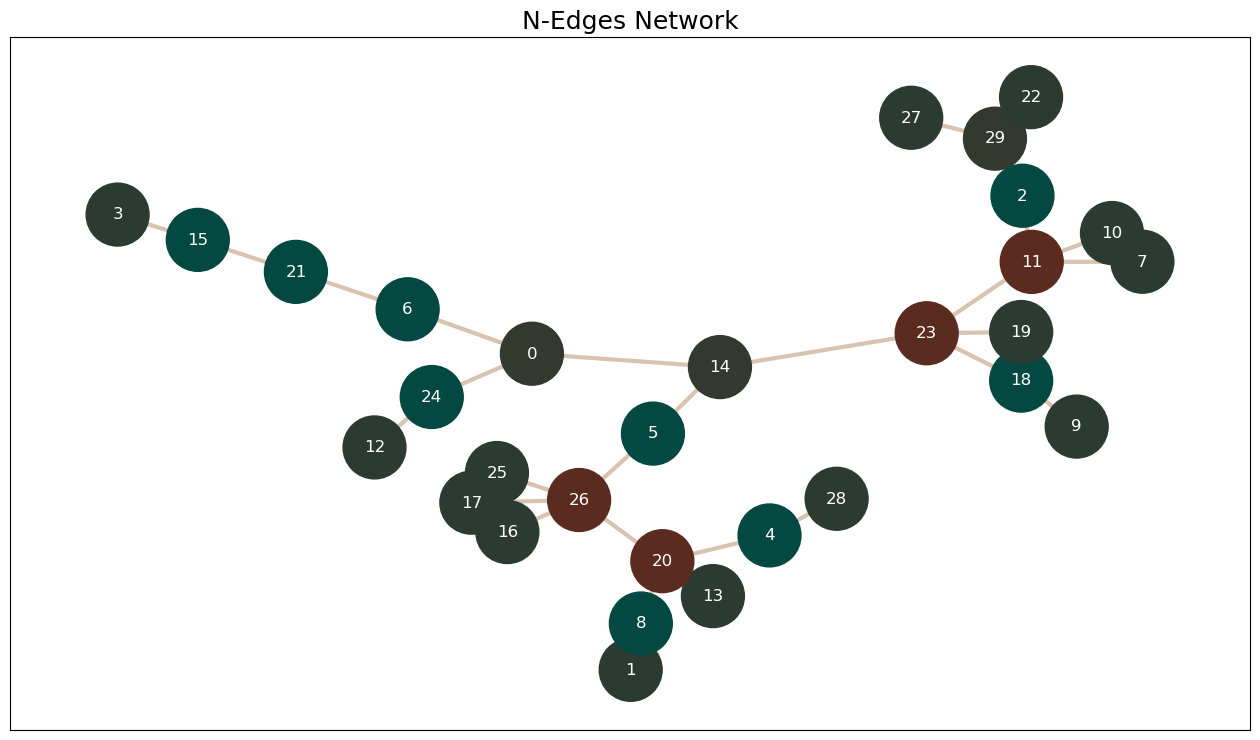

In [18]:
draw_ligand_network(network=nedges_network, title=nedges_network.name);

## Redundant MST

The `RedundantMinimalSpanningTreeNetworkGenerator` is an approach, that tries to minimize the impact of connection failures in an MST-like network.

The network algorithm follows the following steps:
1. Create `n_redundancy` times MST networks, removing the nodes already selected at each iteration.
2. Build an overlay of all the MST networks genreated.

This increases the number of redundant edges, reducing the impact of failures.

In [19]:
from konnektor.network_planners import RedundantMinimalSpanningTreeNetworkGenerator

ligand_network_planner = RedundantMinimalSpanningTreeNetworkGenerator(
    mappers=mapper, scorer=scorer, n_redundancy=2
)

In [20]:
rmst_network = ligand_network_planner.generate_ligand_network(components)
rmst_network.name = "Redundant Min Spanning\n Tree Network"
rmst_network

<LigandNetwork-39d83c6d7f17817fd33e562da66c57a0>

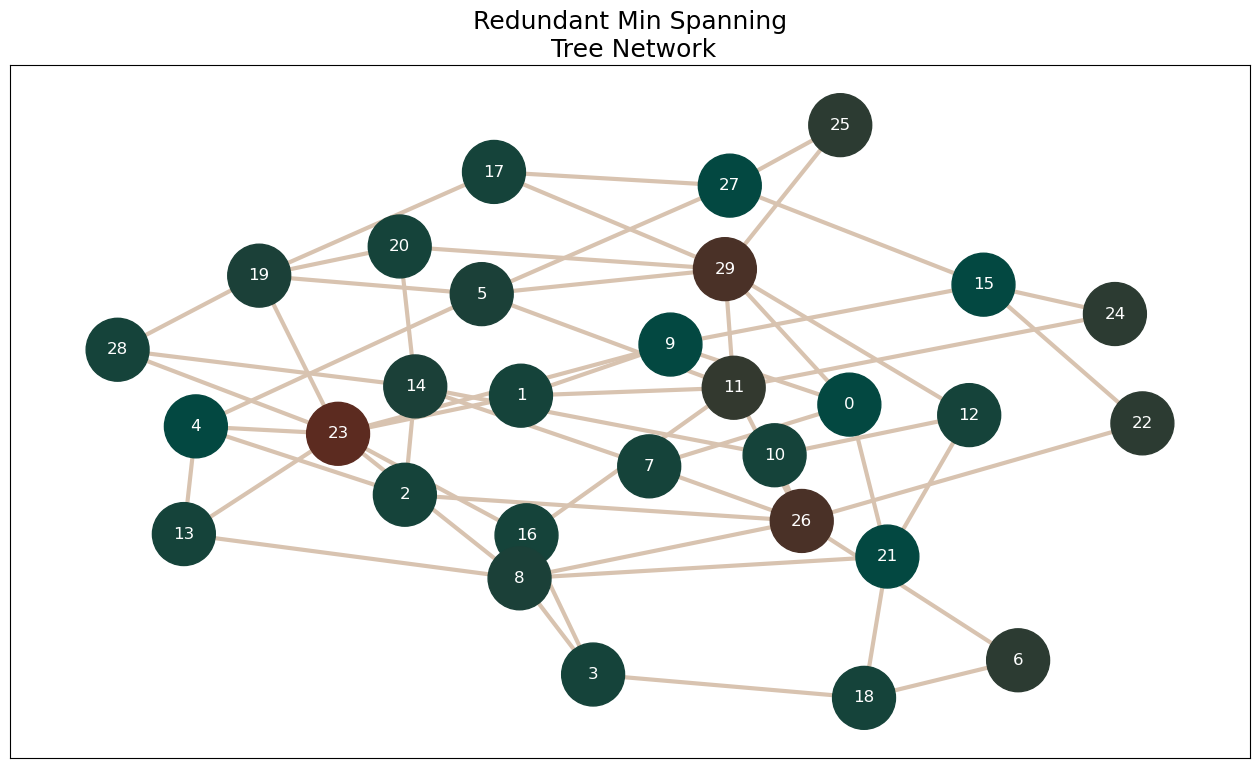

In [21]:
draw_ligand_network(network=rmst_network, title=rmst_network.name);

## Cyclic Network
The `CyclicNetworkGenerator` creates a network with internal cycles within the network. This can be useful in ensuring redundancy and allow for cycle closure analysis.

The network algorithm follows the following steps:
1. For each node, the algorithm generates all cycles of size `cycle_sizes` and assigns a score to each cycle as the sum of all sub-scores.
2. Next it selects the `node_present_in_cycles` best score perfoming and node diversity increasing (see below) cycles per node.
3. From these a graph is constructed.

The node diversity is used to spread the cycle in the network equallly between all the `Component`s.
    
The number of cylces, around each `Component` can be defined by `component_present_in_cycles` and allowed cylce size can be tweaked with `cycle_sizes`. For `cycle_sizes` you can either use an integer for providing an expected cycle size (e.g. `3`) or a range of allowed cycle sizes (e.g. `[3,4]`).

This network topology has a well distributed connectivity between all `Component`s, which increases the robustness but still allows for a better graph score then the `Twin Star Network`, as the connectivity distribution is biased not enforced.

In [22]:
from konnektor.network_planners import CyclicNetworkGenerator

ligand_network_planner = CyclicNetworkGenerator(
    mappers=mapper, scorer=scorer, cycle_sizes=[3, 4], node_present_in_cycles=2
)

In [23]:
cyclic_network = ligand_network_planner.generate_ligand_network(components)
cyclic_network.name = "Cyclic Network"
cyclic_network

<LigandNetwork-67c7771a6d8d7c80cac1acba27609950>

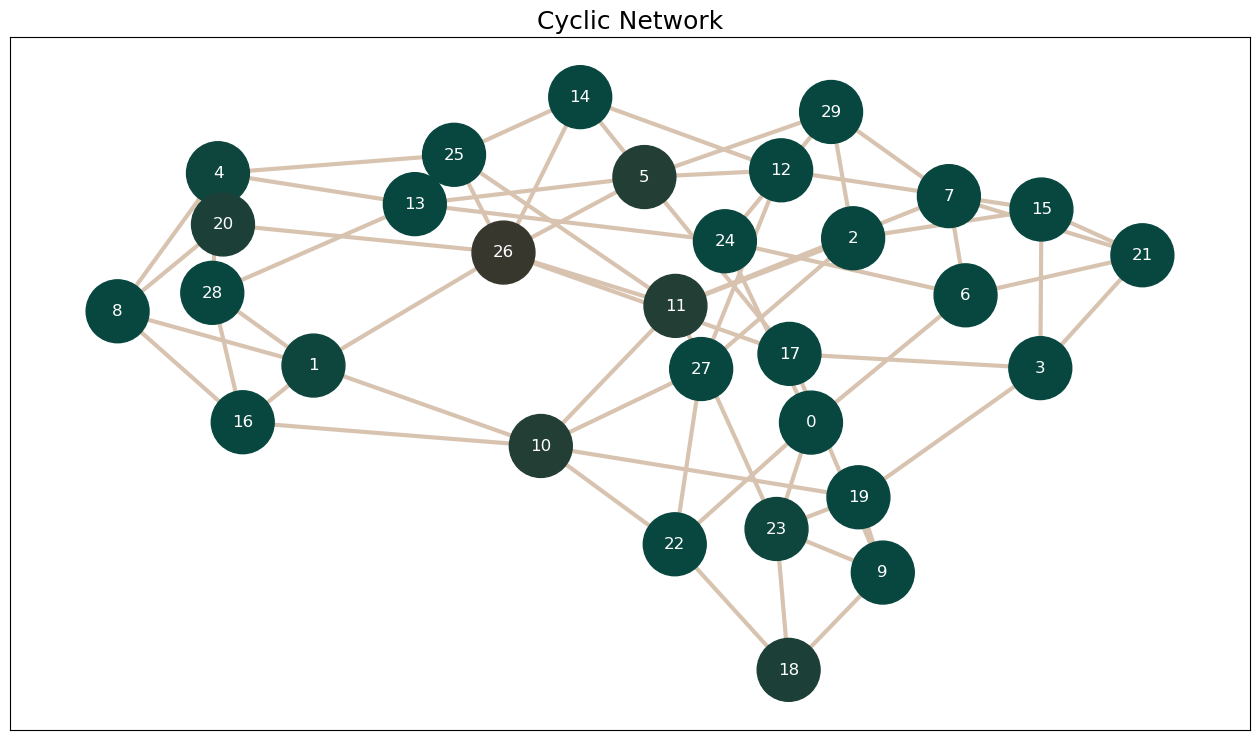

In [24]:
draw_ligand_network(network=cyclic_network, title=cyclic_network.name);

## Maximally connected network
The `MaximalNetworkGenerator` builds a graph of all possible connections between a set of `Component`s.

**Note:** This approach is not very suitable for production use as it has the highest possible graph cost. However, this approach is very important as a precursor to creating all the other network types.

> **Note**: the `MaximalNetworkGenerator` is parallelized and the number of CPUs can be given with  `n_processes`. 
> All other approaches in Konnektor benefit from this parallelization and you can use this parallelization with `n_processes` key word during class construction.


In [25]:
import logging
from konnektor.network_planners import MaximalNetworkGenerator
from kartograf.atom_mapper import logger

logger.setLevel(logging.ERROR)

ligand_network_planner = MaximalNetworkGenerator(
    mappers=mapper, scorer=scorer, n_processes=3
)

In [26]:
max_network = ligand_network_planner.generate_ligand_network(components)
max_network.name = "Maximal Network"
max_network

/Users/atravitz/micromamba/envs/konnektor/lib/python3.12/site-packages/gufe/components/explicitmoleculecomponent.py:74: UserWarning: RDKit does not preserve Mol properties when pickled by default, which may drop e.g. atom charges; consider setting `Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)`
  warnings.warn(
/Users/atravitz/micromamba/envs/konnektor/lib/python3.12/site-packages/gufe/components/explicitmoleculecomponent.py:74: UserWarning: RDKit does not preserve Mol properties when pickled by default, which may drop e.g. atom charges; consider setting `Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)`
  warnings.warn(
/Users/atravitz/micromamba/envs/konnektor/lib/python3.12/site-packages/gufe/components/explicitmoleculecomponent.py:74: UserWarning: RDKit does not preserve Mol properties when pickled by default, which may drop e.g. atom charges; consider setting `Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)`
  warning

<LigandNetwork-07136cff43b761d82be21f72bbb8e02b>

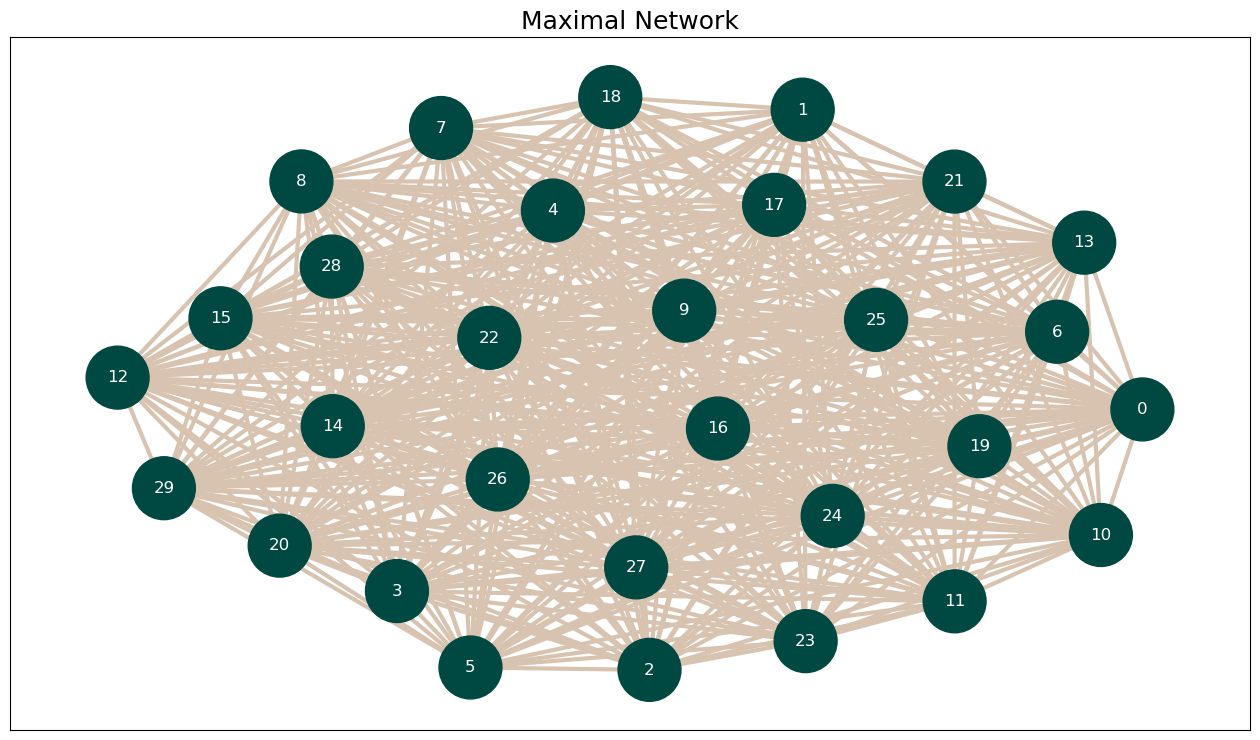

In [27]:
draw_ligand_network(network=max_network, title=max_network.name);

## Heuristic Maximal Network
The `HeuristicMaximalNetworkGenerator` builds a network with `n_samples` connections per `Component` for a given set of `Component`s.

Similar to `MaximalNetworkGenerator` this network can be used as a precursor to other network types.

> **Note**: the `HeuristicMaximalNetworkGenerator` is parallelized and the number of CPUs can be given with  `n_processes`. 

In [28]:
import logging
from konnektor.network_planners import HeuristicMaximalNetworkGenerator
from kartograf.atom_mapper import logger

logger.setLevel(logging.ERROR)

ligand_network_planner = HeuristicMaximalNetworkGenerator(
    mappers=mapper,
    scorer=scorer,
    n_samples=10,
    n_processes=3,
)

In [29]:
hmax_network = ligand_network_planner.generate_ligand_network(components)
hmax_network.name = "Heuristic Maximal\nNetwork"
hmax_network

/Users/atravitz/micromamba/envs/konnektor/lib/python3.12/site-packages/gufe/components/explicitmoleculecomponent.py:74: UserWarning: RDKit does not preserve Mol properties when pickled by default, which may drop e.g. atom charges; consider setting `Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)`
  warnings.warn(
/Users/atravitz/micromamba/envs/konnektor/lib/python3.12/site-packages/gufe/components/explicitmoleculecomponent.py:74: UserWarning: RDKit does not preserve Mol properties when pickled by default, which may drop e.g. atom charges; consider setting `Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)`
  warnings.warn(
/Users/atravitz/micromamba/envs/konnektor/lib/python3.12/site-packages/gufe/components/explicitmoleculecomponent.py:74: UserWarning: RDKit does not preserve Mol properties when pickled by default, which may drop e.g. atom charges; consider setting `Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)`
  warning

<LigandNetwork-d1bf7bcb52c8025fbecd6d51f99c5082>

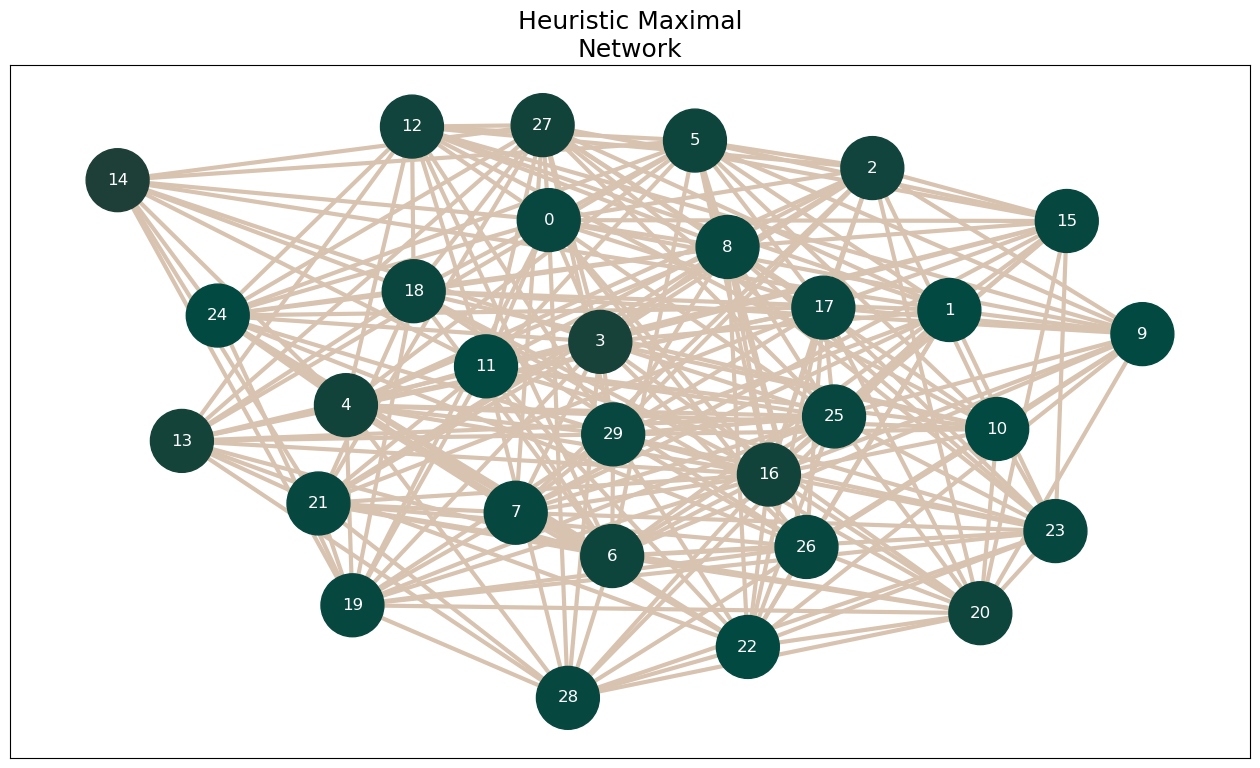

In [30]:
draw_ligand_network(network=hmax_network, title=hmax_network.name);

## Custom Diversity Cluster Network

This class is the powers the `Starry Sky Network` and can be used to create custom clustered network types. Here we demonstrate how it can be used to use Cyclic Networks instead of Star Networks.

The `ClusteredNetworkGenerator` implements the following algorithm:

1. Cluster `Component`s with the `clusterer` obj.
2. Build sub-networks in the clusters using the `sub_network_planners`.
3. Concatenate all sub-networks using the `concatenator` in order to build the final network.

In [31]:
from konnektor.network_planners import ClusteredNetworkGenerator
from konnektor.network_planners import CyclicNetworkGenerator
from konnektor.network_planners import MstConcatenator

sub_network_planner = CyclicNetworkGenerator(mappers=mapper, scorer=scorer)
network_concatenator = MstConcatenator(mappers=mapper, scorer=scorer)
ligand_network_planner = ClusteredNetworkGenerator(
    sub_network_planners=sub_network_planner, concatenator=network_concatenator
)

In [32]:
div_network = ligand_network_planner.generate_ligand_network(components)
div_network.name = "Diversity Clustering\nNetwork"
div_network

/Users/atravitz/micromamba/envs/konnektor/lib/python3.12/site-packages/gufe/components/explicitmoleculecomponent.py:74: UserWarning: RDKit does not preserve Mol properties when pickled by default, which may drop e.g. atom charges; consider setting `Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)`
  warnings.warn(
/Users/atravitz/micromamba/envs/konnektor/lib/python3.12/site-packages/gufe/components/explicitmoleculecomponent.py:74: UserWarning: RDKit does not preserve Mol properties when pickled by default, which may drop e.g. atom charges; consider setting `Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)`
  warnings.warn(
/Users/atravitz/micromamba/envs/konnektor/lib/python3.12/site-packages/gufe/components/explicitmoleculecomponent.py:74: UserWarning: RDKit does not preserve Mol properties when pickled by default, which may drop e.g. atom charges; consider setting `Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)`
  warning

<LigandNetwork-176d357d962b16325ecc9ea8944f7e69>

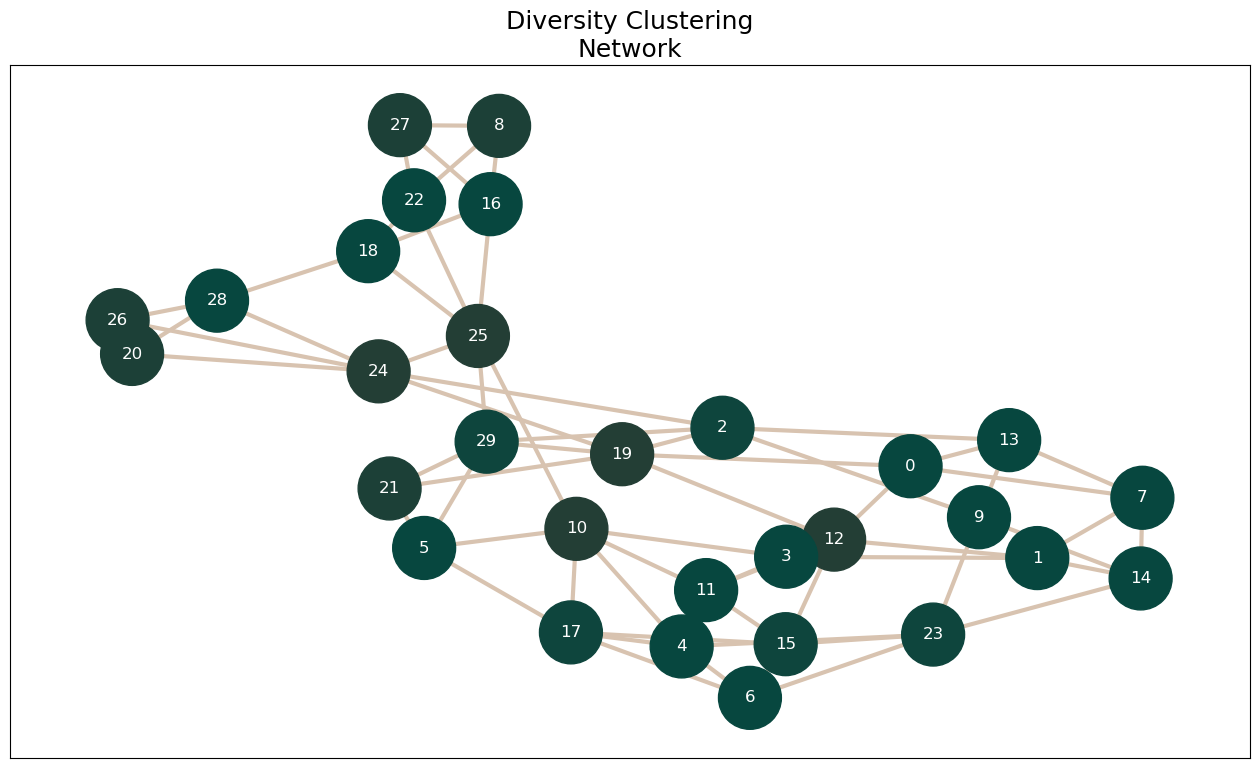

In [33]:
draw_ligand_network(network=div_network, title=div_network.name);

## Summary
Let's generate a nice summary figure, with all the shown network layouts.

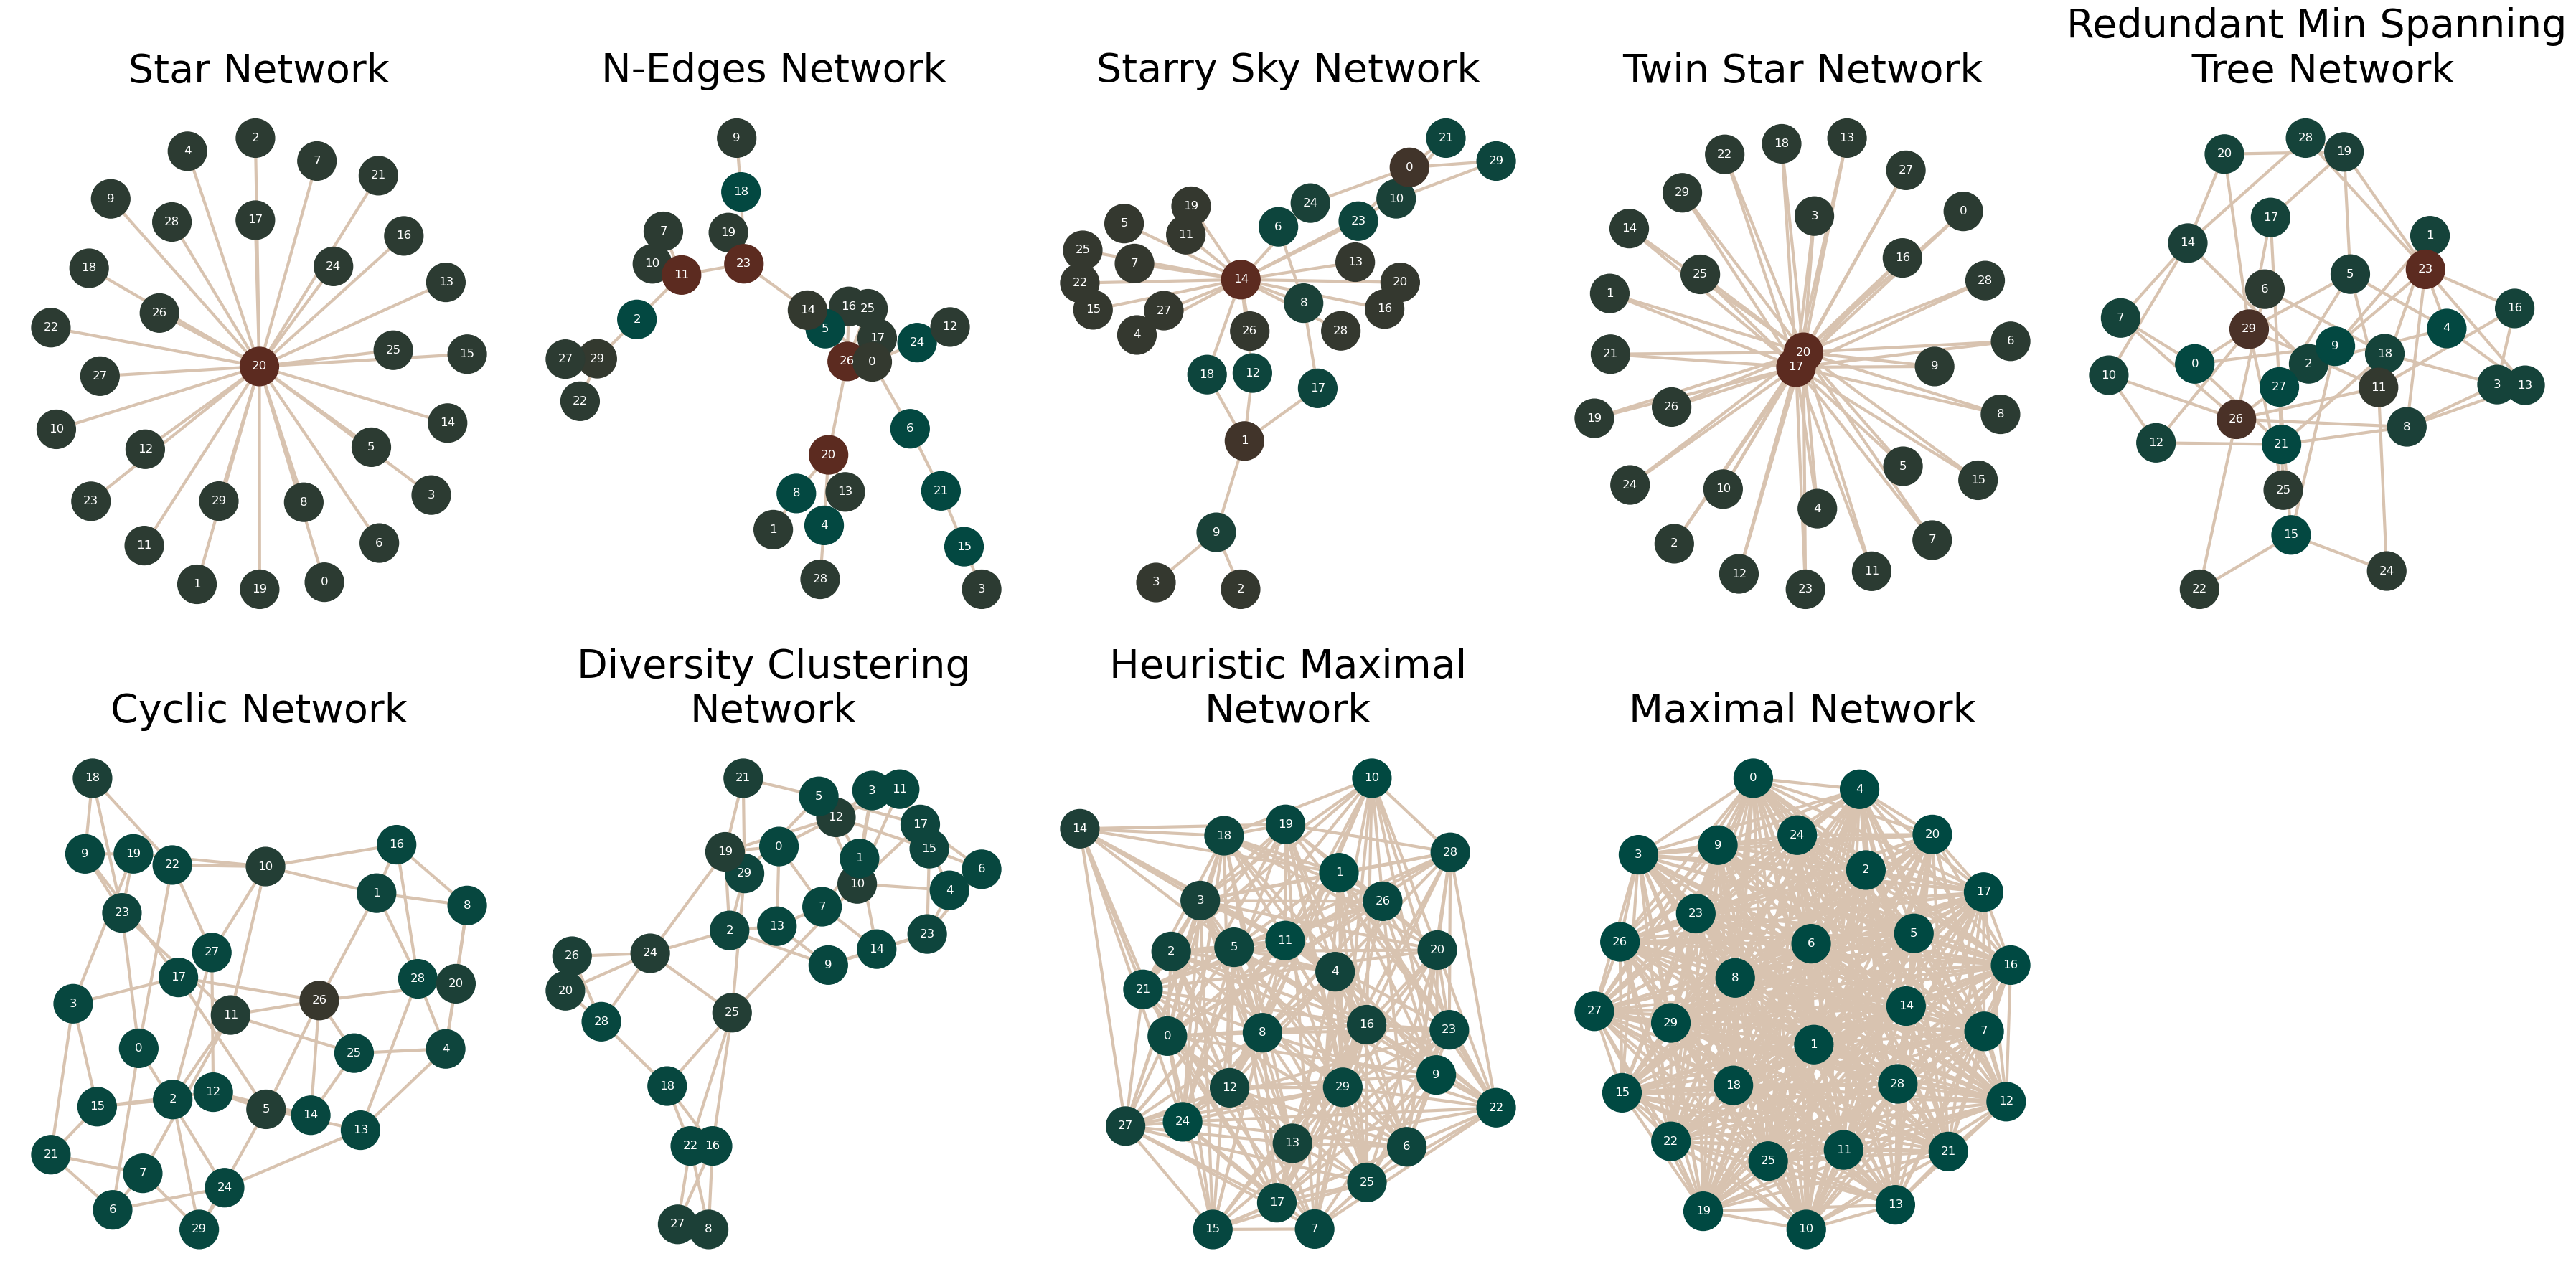

In [34]:
networks = [
    star_network,
    twin_star_network,
    starry_sky_network,
    nedges_network,
    rmst_network,
    cyclic_network,
    div_network,
    hmax_network,
    max_network,
]

networks = list(sorted(networks, key=lambda x: len(x.edges)))

import numpy as np
from matplotlib import pyplot as plt

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=[9 * 4, 2 * 9])
axes = np.array(axes).flat
fs = 22
for ax, net in zip(axes, networks):
    draw_ligand_network(network=net, title=net.name, ax=ax, node_size=1500, fontsize=40)
    ax.axis("off")
axes[-1].axis("off")
fig.tight_layout()

In [35]:
# NBVAL_SKIP
fig.savefig("./network_layouts.png", dpi=400)